# Fine-tuning for Object Detection with 🤗 Transformers

This notebook shows how to fine-tune a pre-trained Vision model for Object Detection on a custom dataset. 

## Dataset

This notebook uses a [CPPE-5](https://huggingface.co/datasets/cppe-5) that contains images with annotations identifying medical personal protective equipment (PPE) in the context of the COVID-19 pandemic. 

## Model

We'll fine-tune [DETR](https://huggingface.co/docs/transformers/model_doc/detr), a model that combines a convolutional backbone with an encoder-decoder Transformer. Here we'll use DETR with ResNet-50 backbone, which was trained on 118k annotated images from [COCO 2017 object detection dataset](https://cocodataset.org/#download). 
 
You can find other variants of DETR [available on 🤗 Hub](https://huggingface.co/models?search=detr). 

## Data preprocessing

When using your own custom data, make sure the annotations follow the [COCO format](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/#coco), and the bounding boxes do not extend beyond image borders. For data augmentation, use whichever library you prefer. Here we are using [Albumentations](https://albumentations.ai/docs/). 

---

Depending on the model and the GPU you are using, you might need to adjust the batch size to avoid out-of-memory errors. 

In [1]:
model_checkpoint = "facebook/detr-resnet-50" # pre-trained model from which to fine-tune
batch_size = 8

Before we start, let's install the following libraries: 
- `datasets` to load a dataset from the 🤗 Hub 
- `transformers` to train your model
- `evaluate` to run evaluation on the fine-tuned model
- `albumentations` to augment the data
- `timm` to load a convolutional backbone for the DETR model


In [2]:
! pip install -q datasets transformers evaluate timm albumentations

If you're opening this notebook locally, make sure your environment has the latest version of these libraries installed.

To be able to share your model with the community and generate results like the one shown in the picture below via the inference API, follow these steps: 
1. Sign in (or sign up if you haven't already) to your [Hugging Face account](https://huggingface.co/join).
2. In your profile's settings get an authentication token. 
3. Execute the following cell and input your token:


In [3]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.huggingface/token
Login successful


## Load the CPPE-5 dataset

First, we'll load the dataset from 🤗 Hub:

In [4]:
from datasets import load_dataset

cppe5 = load_dataset("cppe-5")
cppe5

  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 29
    })
})

This dataset already comes with a training set containing 1000 images and a test set with 29 images.

To get familiar with the data, let's explore what the examples look like.

In [5]:
cppe5['train'][0]

{'image_id': 15,
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=943x663 at 0x7FCA6A3DCE20>,
 'width': 943,
 'height': 663,
 'objects': {'id': [114, 115, 116, 117],
  'area': [3796, 1596, 152768, 81002],
  'bbox': [[302.0, 109.0, 73.0, 52.0],
   [810.0, 100.0, 57.0, 28.0],
   [160.0, 31.0, 248.0, 616.0],
   [741.0, 68.0, 202.0, 401.0]],
  'category': [4, 4, 0, 0]}}

The `bbox` field follows the [COCO format](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/#coco), which is the format that DETR model expects. However, the grouping of the fields inside `objects` differs from the annotation format DETR requires. We'll reformat the annotations appropriately at the preprocessing step.

Next, we set up two dictionaries:
- `label2id` which maps the class labels to integers
- `id2label` doing the opposite of `label2id`.

These dictionaries will be useful for plotting examples and for setting up the model.

In [6]:
# get the category names from the dataset's metadata
categories = cppe5['train'].features['objects'].feature['category'].names

id2label = {index: x for index, x in enumerate(categories, start=0)}
label2id = {v: k for k, v in id2label.items()}


To get a better understanding of the data, it is helpful to visualize an example in the dataset.

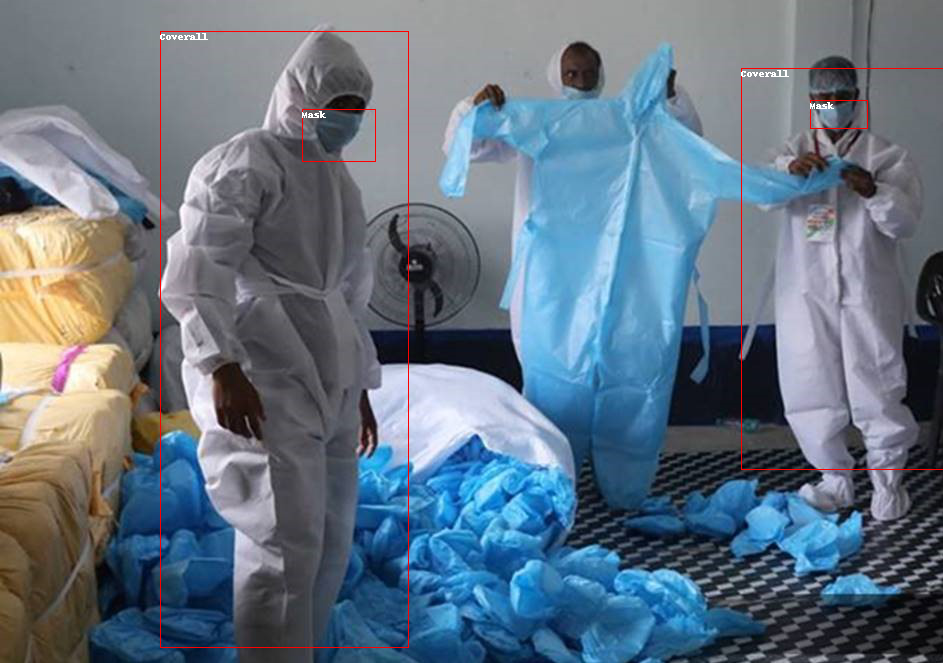

In [7]:
import numpy as np
import os
from PIL import Image, ImageDraw

image = cppe5['train'][0]['image']
annotations = cppe5['train'][0]['objects']
draw = ImageDraw.Draw(image)

for i in range(len(annotations['id'])):
  box = annotations['bbox'][i-1]
  class_idx = annotations['category'][i-1]
  x,y,w,h = tuple(box)
  draw.rectangle((x,y,x+w,y+h), outline='red', width=1)
  draw.text((x, y), id2label[class_idx], fill='white')

image

For simplicity, in this notebook we remove images that have bounding boxes stretching beyond image boundaries. If you're using your own data, you may need to add some data checks.


In [8]:
remove_idx = [590, 821, 822, 875, 876, 878, 879]
keep = [i for i in range(len(cppe5["train"])) if i not in remove_idx]
cppe5["train"] = cppe5["train"].select(keep)

## Preprocess the data

To finetune a model, we must preprocess the data in precisely the same manner as it was done for the pre-trained model.
[`AutoImageProcessor`] takes care of processing image data to create `pixel_values`, `pixel_mask`, and
`labels` that a DETR model can train with. The image processor has some crucial attributes that we won't have to worry about:

- `image_mean = [0.485, 0.456, 0.406 ]`
- `image_std = [0.229, 0.224, 0.225]`

These are the mean and standard deviation used to normalize images during the model pre-training. 

Let's instantiate the image processor from the same checkpoint as the model we plan to finetune.

In [9]:
from transformers import AutoImageProcessor

image_processor = AutoImageProcessor.from_pretrained(model_checkpoint)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
/usr/local/lib/python3.8/dist-packages/transformers/models/detr/image_processing_detr.py:773: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(


Before passing the images to the `image_processor`, we'll apply two preprocessing transformations to the dataset:
- Augmenting images
- Re-formatting annotations to meet DETR expectations

For image augmentation we'll use [Albumentations](https://albumentations.ai/docs/) to ensure that transformations affect the image and update the bounding boxes accordingly. You can use any other augmentation library of your choice. Here we resize each image to (480, 480), flip it horizontally, and brighten it:

In [10]:
import albumentations
import numpy as np
import torch

transform = albumentations.Compose([
    albumentations.Resize(480, 480),
    albumentations.HorizontalFlip(p=1.0),
    albumentations.RandomBrightnessContrast(p=1.0),
], bbox_params=albumentations.BboxParams(format='coco',  label_fields=['category']))


The `image_processor` for DETR model expects the annotations to be in the following format: `{'image_id': int, 'annotations': List[Dict]}`,
 where each dictionary is a COCO object annotation. Let's add a function to reformat annotations for a single example:

In [11]:
def formatted_anns(image_id, category, area, bbox):
  
  annotations = []
  for i in range(0,len(category)):
    new_ann = {"image_id": image_id,
          "category_id": category[i],
          "isCrowd": 0,
          "area": area[i],
          "bbox": list(bbox[i])}
    annotations.append(new_ann)
    
  return annotations 

Now we can combine the image and annotation transformations to use on a batch of examples:

In [12]:
# transforming a batch
def transform_aug_ann(examples):
  image_ids = examples["image_id"]
  images, bboxes, area, categories = [], [], [], []
  for image, objects in zip(examples['image'], examples['objects']):
    image = np.array(image.convert("RGB"))[:, :, ::-1]
    out = transform(
        image=image,
        bboxes=objects['bbox'],
        category=objects['category']
        )
  
    area.append(objects['area'])
    images.append(out['image'])
    bboxes.append(out['bboxes'])    
    categories.append(out['category'])

  targets = [
      {"image_id": id_, "annotations": formatted_anns(id_, cat_, ar_, box_)} 
      for id_, cat_, ar_, box_  in zip(image_ids, categories, area, bboxes)
  ]

  return image_processor(images=images, annotations=targets, return_tensors="pt")

We can apply this preprocessing function to the entire dataset using 🤗 Datasets `with_transform()` method. This method applies transformations on the fly when you load an element of the dataset.

At this point, we can check what an example from the dataset looks like after the transformations. You should see a tensor with `pixel_values`, a tensor with `pixel_mask`, and `labels`.

In [13]:
cppe5["train"] = cppe5["train"].with_transform(transform_aug_ann)
cppe5["train"][15]

/usr/local/lib/python3.8/dist-packages/transformers/models/detr/image_processing_detr.py:856: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(


{'pixel_values': tensor([[[ 1.5125,  1.5125,  1.5125,  ..., -1.4843, -1.4843, -1.4843],
          [ 1.5125,  1.5125,  1.5125,  ..., -1.4843, -1.4843, -1.4843],
          [ 1.5125,  1.5125,  1.5125,  ..., -1.4672, -1.4672, -1.4672],
          ...,
          [-1.0562, -1.0562, -1.0562,  ..., -1.5014, -1.5014, -1.5014],
          [-1.0390, -1.0390, -1.0390,  ..., -1.5014, -1.4843, -1.4843],
          [-1.0390, -1.0390, -1.0390,  ..., -1.5014, -1.4843, -1.4843]],
 
         [[ 1.9384,  1.9384,  1.9384,  ..., -1.3354, -1.3354, -1.3354],
          [ 1.9384,  1.9384,  1.9384,  ..., -1.3354, -1.3354, -1.3354],
          [ 1.9384,  1.9384,  1.9384,  ..., -1.3179, -1.3179, -1.3179],
          ...,
          [-0.7927, -0.7927, -0.7927,  ..., -1.3529, -1.3529, -1.3529],
          [-0.7752, -0.7752, -0.7752,  ..., -1.3529, -1.3354, -1.3354],
          [-0.7577, -0.7577, -0.7577,  ..., -1.3529, -1.3354, -1.3354]],
 
         [[ 2.0474,  2.0474,  2.0474,  ..., -1.1421, -1.1421, -1.1421],
          [ 

We have successfully augmented the individual images and prepared their annotations. However, preprocessing isn't complete yet. In the final step, we create a custom `collate_fn` to batch images together. Pad images (which are now `pixel_values`) to the largest image in a batch, and create a corresponding `pixel_mask` to indicate which pixels are real (1) and which are padding (0).

In [14]:
def collate_fn(batch):
  pixel_values = [item['pixel_values'] for item in batch]
  encoding = image_processor.pad_and_create_pixel_mask(pixel_values, return_tensors="pt")
  labels = [item['labels'] for item in batch]
  batch = {}
  batch['pixel_values'] = encoding['pixel_values']
  batch['pixel_mask'] = encoding['pixel_mask']
  batch['labels'] = labels
  return batch

## Training the DETR model

Now we are ready to train the model! The images in this dataset are still quite large, even after resizing. This means that finetuning this model will require at least one GPU.
Training involves the following steps:

1. Load the model with `AutoModelForObjectDetection` using the same checkpoint as in the preprocessing.
2. Define your training hyperparameters in `TrainingArguments`.
3. Pass the training arguments to `Trainer` along with the model, dataset, image processor, and data collator.
4. Call `train()` to finetune your model.

When loading the model from the same checkpoint as we used for the preprocessing, we need to pass the `label2id` and `id2label` maps that were created earlier from the dataset's metadata. 

NOTE: Because the number of categories in our dataset differs from the number of categories DETR was pre-trained with, we need to set `ignore_mismatched_sizes=True`. This will create a randomly initialized classification head that includes a custom number of output neurons. 

In [15]:
from transformers import AutoModelForObjectDetection

model = AutoModelForObjectDetection.from_pretrained(
    model_checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([6, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([6]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In the `TrainingArguments` use `output_dir` to specify where to save your model, then configure hyperparameters as you see fit. It is important not to remove unused columns because this will drop the image column. Without the image column, you can't create `pixel_values`. For this reason, set `remove_unused_columns` to `False`. If you wish to share your model by pushing to the Hub, set `push_to_hub` to `True` (you must be signed in to Hugging Face to upload your model).

In [16]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="detr-resnet-50_finetuned_cppe5",
    per_device_train_batch_size=batch_size,
    num_train_epochs=20,
    fp16=True,
    save_steps=200,
    logging_steps=50,
    learning_rate=1e-5,
    weight_decay=1e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=True,
)

Finally, let's bring everything together, and call `train()`:

In [17]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=cppe5["train"],
    tokenizer=image_processor,
)

trainer.train()

/content/detr-resnet-50_finetuned_cppe5 is already a clone of https://huggingface.co/MariaK/detr-resnet-50_finetuned_cppe5. Make sure you pull the latest changes with `repo.git_pull()`.
Using cuda_amp half precision backend
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 993
  Num Epochs = 20
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2500
  Number of trainable parameters = 41287434
/usr/local/lib/python3.8/dist-packages/transformers/models/detr/image_processing_detr.py:856: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.2

Step,Training Loss
50,3.920600
100,2.925800
150,2.492900
200,2.311000
250,2.188300
300,2.124200
350,2.096700
400,2.184300
450,2.009800
500,1.917200


Saving model checkpoint to detr-resnet-50_finetuned_cppe5/checkpoint-200
Configuration saved in detr-resnet-50_finetuned_cppe5/checkpoint-200/config.json
Model weights saved in detr-resnet-50_finetuned_cppe5/checkpoint-200/pytorch_model.bin
Image processor saved in detr-resnet-50_finetuned_cppe5/checkpoint-200/preprocessor_config.json
Image processor saved in detr-resnet-50_finetuned_cppe5/preprocessor_config.json
/usr/local/lib/python3.8/dist-packages/transformers/models/detr/image_processing_detr.py:856: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/transformers/models/detr/image_processing_detr.py:940: FutureWarning: This method is deprecated and will be removed in v4.27.0. Please use pad instead.
  warnings.warn(
Saving model checkpoint to detr-resnet-50_finetuned_cppe5/checkpoint-400
Configuration saved in detr-resnet-50_finetuned_cppe5/ch

TrainOutput(global_step=2500, training_loss=1.7827344665527343, metrics={'train_runtime': 3767.2541, 'train_samples_per_second': 5.272, 'train_steps_per_second': 0.664, 'total_flos': 9.4911788800512e+18, 'train_loss': 1.7827344665527343, 'epoch': 20.0})

If you have set `push_to_hub` to `True` in the `training_args`, the checkpoints during training are pushed to the Hugging Face Hub. Upon training completion, we can push the final model to the Hub as well by calling the `push_to_hub()` method.

In [18]:
trainer.push_to_hub()

Saving model checkpoint to detr-resnet-50_finetuned_cppe5
Configuration saved in detr-resnet-50_finetuned_cppe5/config.json
Model weights saved in detr-resnet-50_finetuned_cppe5/pytorch_model.bin
Image processor saved in detr-resnet-50_finetuned_cppe5/preprocessor_config.json


Upload file pytorch_model.bin:   0%|          | 3.30k/159M [00:00<?, ?B/s]

Upload file runs/Jan03_22-35-56_c4d928ecf092/events.out.tfevents.1672785364.c4d928ecf092.56216.0:  27%|##6    …

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/MariaK/detr-resnet-50_finetuned_cppe5
   35b4849..40725a6  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/MariaK/detr-resnet-50_finetuned_cppe5
   35b4849..40725a6  main -> main

Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Object Detection', 'type': 'object-detection'}, 'dataset': {'name': 'cppe-5', 'type': 'cppe-5', 'config': 'default', 'split': 'train', 'args': 'default'}}
To https://huggingface.co/MariaK/detr-resnet-50_finetuned_cppe5
   40725a6..1747385  main -> main

   40725a6..1747385  main -> main



'https://huggingface.co/MariaK/detr-resnet-50_finetuned_cppe5/commit/40725a601f7b88c0953fc0707644097c687ad411'

## Evaluation

Object detection models are commonly evaluated with a set of [COCO-style metrics](https://cocodataset.org/#detection-eval). You can use one of the existing metrics implementations, but here we'll use the one from `torchvision` to evaluate the final model that we pushed to Hub.

To use the `torchvision` evaluator, we need to prepare a ground truth COCO dataset. The API to build a COCO dataset requires the data to be stored in a certain format, so we need to save images and annotations to disk first. Just like when we prepared your data for training, the annotations from the `cppe5["test"]` need to be formatted. However, images should stay as they are.

The evaluation step requires a bit of work, but it can be split in three major steps. First, let's prepare the `cppe5["test"]` set: format the annotations and save the data to disk.


In [19]:
# prepare the cppe5["test"] dataset to be loaded into torchvision.datasets.CocoDetection
import json 

# format annotations the same as for training, but no need to do data augmentation
def val_formatted_anns(image_id, objects):
  annotations = []
  for i in range(0,len(objects["id"])):
    new_ann = {"id": objects["id"][i],
          "category_id": objects["category"][i],
          "iscrowd": 0,
          "image_id": image_id,
          "area": objects["area"][i],
          "bbox": objects["bbox"][i]}
    annotations.append(new_ann)
    
  return annotations 

# Save images and annotations into the files torchvision.datasets.CocoDetection expects
def save_cppe5_annotation_file_images(cppe5):
  output_json = {}
  path_output_cppe5 = f"{os.getcwd()}/cppe5/"

  if not os.path.exists(path_output_cppe5):
    os.makedirs(path_output_cppe5)

  path_anno = os.path.join(path_output_cppe5, "cppe5_ann.json")
  categories_json = [{"supercategory": "none", "id": id, "name": id2label[id]} for id in id2label ]
  output_json["images"] = []
  output_json["annotations"] = []
  for example in cppe5:
      ann = val_formatted_anns(example["image_id"], example["objects"])
      output_json["images"].append(
        {
          "id": example["image_id"],
          "width": example["image"].width,
          "height": example["image"].height,
          "file_name": f"{example['image_id']}.png"
        }
      )
      output_json["annotations"].extend(ann)
  output_json["categories"] = categories_json

  with open(path_anno, "w") as file:
      json.dump(output_json, file, ensure_ascii=False, indent=4)

  for im, img_id in zip(cppe5["image"], cppe5["image_id"]):
      path_img = os.path.join(path_output_cppe5, f"{img_id}.png")
      im.save(path_img)
  
  return path_output_cppe5, path_anno

Next, we'll prepare an instance of a `CocoDetection` class that can be used with cocoevaluator.

In [20]:
import torchvision

class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, feature_extractor, ann_file):
        super().__init__(img_folder, an_file)
        self.feature_extractor = feature_extractor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        img, target = super(CocoDetection, self).__getitem__(idx)
        
        # preprocess image and target: converting target to DETR format,
        # resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.feature_extractor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        target = encoding["labels"][0] # remove batch dimension

        return {"pixel_values":pixel_values, "labels":target}

im_processor = AutoImageProcessor.from_pretrained("MariaK/detr-resnet-50_finetuned_cppe5")

path_output_cppe5, path_anno = save_cppe5_annotation_file_images(cppe5["test"])
test_ds_coco_format = CocoDetection(path_output_cppe5, im_processor, path_anno)

loading configuration file preprocessor_config.json from cache at /root/.cache/huggingface/hub/models--MariaK--detr-resnet-50_finetuned_cppe5/snapshots/1747385a6c6f9ed41121d4aec3e1ec759d8bbd25/preprocessor_config.json
Image processor DetrImageProcessor {
  "do_normalize": true,
  "do_pad": true,
  "do_rescale": true,
  "do_resize": true,
  "format": "coco_detection",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "DetrImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "longest_edge": 1333,
    "shortest_edge": 800
  }
}



loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


Finally, we can load the metrics and run the evaluation.

In [21]:
import evaluate
from tqdm import tqdm

model = AutoModelForObjectDetection.from_pretrained("MariaK/detr-resnet-50_finetuned_cppe5")
module = evaluate.load("ybelkada/cocoevaluate", coco=test_ds_coco_format.coco)
val_dataloader = torch.utils.data.DataLoader(
    test_ds_coco_format, batch_size=8, shuffle=False, num_workers=4, collate_fn=collate_fn
)

with torch.no_grad():
    for idx, batch in enumerate(tqdm(val_dataloader)):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]

        labels = [
            {k: v for k, v in t.items()} for t in batch["labels"]
        ]  # these are in DETR format, resized + normalized

        # forward pass
        outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

        orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
        results = im_processor.post_process(outputs, orig_target_sizes)  # convert outputs of model to COCO api

        module.add(prediction=results, reference=labels)
        del batch

results = module.compute()
print(results)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--MariaK--detr-resnet-50_finetuned_cppe5/snapshots/1747385a6c6f9ed41121d4aec3e1ec759d8bbd25/config.json
Model config DetrConfig {
  "_name_or_path": "MariaK/detr-resnet-50_finetuned_cppe5",
  "activation_dropout": 0.0,
  "activation_function": "relu",
  "architectures": [
    "DetrForObjectDetection"
  ],
  "attention_dropout": 0.0,
  "auxiliary_loss": false,
  "backbone": "resnet50",
  "bbox_cost": 5,
  "bbox_loss_coefficient": 5,
  "class_cost": 1,
  "d_model": 256,
  "decoder_attention_heads": 8,
  "decoder_ffn_dim": 2048,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "dice_loss_coefficient": 1,
  "dilation": false,
  "dropout": 0.1,
  "encoder_attention_heads": 8,
  "encoder_ffn_dim": 2048,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 6,
  "eos_coefficient": 0.1,
  "giou_cost": 2,
  "giou_loss_coefficient": 2,
  "id2label": {
    "0": "Coverall",
    "1": "Face_Shield",
    "2": "Glove

Downloading:   0%|          | 0.00/167M [00:00<?, ?B/s]

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--MariaK--detr-resnet-50_finetuned_cppe5/snapshots/1747385a6c6f9ed41121d4aec3e1ec759d8bbd25/pytorch_model.bin
All model checkpoint weights were used when initializing DetrForObjectDetection.

All the weights of DetrForObjectDetection were initialized from the model checkpoint at MariaK/detr-resnet-50_finetuned_cppe5.
If your task is similar to the task the model of the checkpoint was trained on, you can already use DetrForObjectDetection for predictions without further training.
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if ne

Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.140
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.252
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.139
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.024
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.047
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.139
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.134
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.251
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.279
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.087
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.132
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

These results can be further improved by adjusting the hyperparameters in `TrainingArguments`. Give it a go!

## Inference

Now that we have finetuned a DETR model, evaluated it, and uploaded it to the Hugging Face Hub, we can use it for inference. The simplest way to try out a finetuned model for inference is to use it in a [Pipeline](https://huggingface.co/docs/transformers/v4.25.1/en/main_classes/pipelines#transformers.pipeline). We can instantiate a pipeline for object detection with our model, and pass an image to it:

In [ ]:
from transformers import pipeline
import requests

url = "https://i.imgur.com/2lnWoly.jpg"
image = Image.open(requests.get(url, stream=True).raw)

obj_detector = pipeline("object-detection", model="MariaK/detr-resnet-50_finetuned_cppe5")
obj_detector(image)

You can also manually replicate the results of the pipeline if you'd like:

In [36]:
image_processor = AutoImageProcessor.from_pretrained("MariaK/detr-resnet-50_finetuned_cppe5")
model = AutoModelForObjectDetection.from_pretrained("MariaK/detr-resnet-50_finetuned_cppe5")

with torch.no_grad():
    inputs = image_processor(images=image, return_tensors="pt")
    outputs = model(**inputs)
    target_sizes = torch.tensor([image.size[::-1]])
    results = image_processor.post_process_object_detection(outputs, threshold=0.55, target_sizes=target_sizes)[0]

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {model.config.id2label[label.item()]} with confidence "
        f"{round(score.item(), 3)} at location {box}"
    )

loading configuration file preprocessor_config.json from cache at /root/.cache/huggingface/hub/models--MariaK--detr-resnet-50_finetuned_cppe5/snapshots/1747385a6c6f9ed41121d4aec3e1ec759d8bbd25/preprocessor_config.json
Image processor DetrImageProcessor {
  "do_normalize": true,
  "do_pad": true,
  "do_rescale": true,
  "do_resize": true,
  "format": "coco_detection",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "DetrImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "longest_edge": 1333,
    "shortest_edge": 800
  }
}

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--MariaK--detr-resnet-50_finetuned_cppe5/snapshots/1747385a6c6f9ed41121d4aec3e1ec759d8bbd25/config.json
Model config DetrConfig {
  "_name_or_path": "MariaK/detr-resnet-50_finetuned_cppe5",
  "activation_dropout": 0.0,
  "activation_function": "relu",
  "ar

Detected Mask with confidence 0.556 at location [411.87, 132.21, 530.93, 232.45]
Detected Coverall with confidence 0.779 at location [217.34, 30.38, 597.33, 526.56]


Let's plot the result

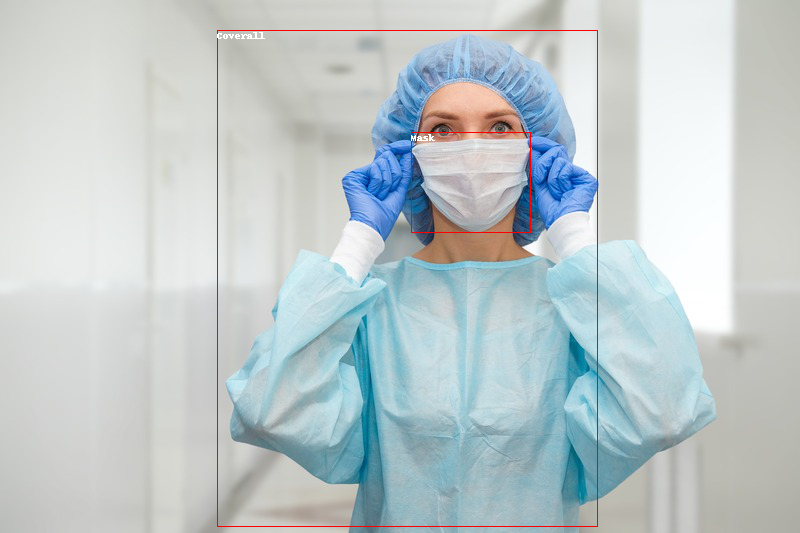

In [37]:
draw = ImageDraw.Draw(image)

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    x, y, x2, y2 = tuple(box)
    draw.rectangle((x, y, x2, y2), outline="red", width=1)
    draw.text((x, y), model.config.id2label[label.item()], fill="white")

image